# QnA | Question 1
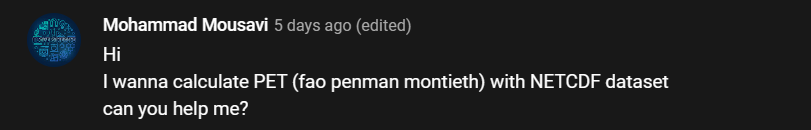

# <a href="https://wetlandscapes.github.io/blog/blog/penman-monteith-and-priestley-taylor/#:~:text=The%20slope%20of%20the%20saturation%20vapor%20pressure%20curve%2C,Delta%20%3D%20frac%7B4098%20cdot%20e_s%7D%7B%28T_a%20%2B%20237.3%29%5E2%7D%20%5D">FAO Penmann-Monteith PET</a>
https://wetlandscapes.github.io/blog/blog/penman-monteith-and-priestley-taylor/#:~:text=The%20slope%20of%20the%20saturation%20vapor%20pressure%20curve%2C,Delta%20%3D%20frac%7B4098%20cdot%20e_s%7D%7B%28T_a%20%2B%20237.3%29%5E2%7D%20%5D

# Method 1

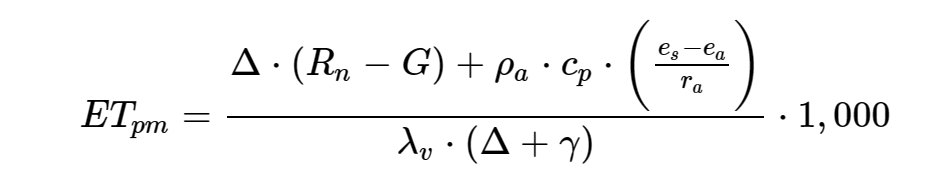

# Method 2

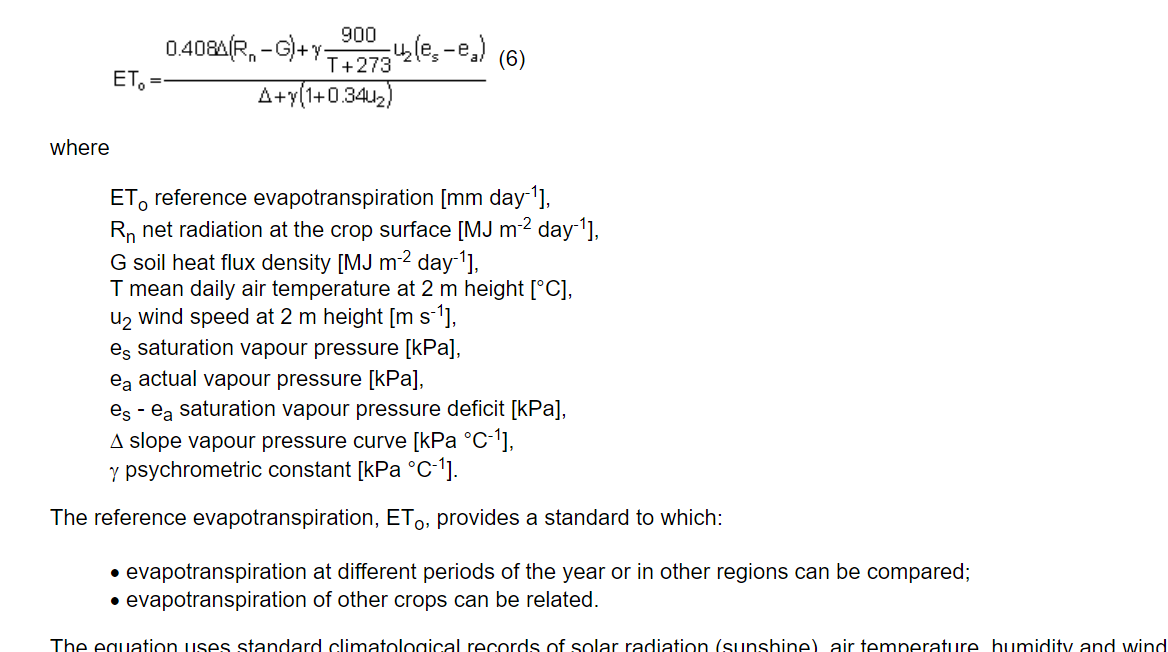

In [ ]:
class FAO_PM_PET:
    def ET_o(method=1,  Rn=None, G=None, T=None, u2=None, es=None, ea=None, slope_vp=None, gamma=None, ra=None, rho_a=None, cp=None):
        '''
        method (1) is no-T approach
        ETpm,o : Penman-Monteith evapotranspiration in m day-1 (*1000 gives mm day-1)
        λv: Volumetric latent heat of vaporization, 2453 MJ m-3
        slope_vp(Δ): Slope of the saturation vapor pressure-temperature curve (kPa C-1)
        Rn: Net radiation (MJ m-2 day-1)
        G: Soil heat flux density (MJ m-2 day-1)
        ρa: Air density for a given air pressure (kg m-3)
        cp: Specific heat of air (MJ kg-1 C-1)
        es: Saturation vapor pressure (kPa)
        ea: Actual vapor pressure (kPa)
        ra: Air resistance (day m-1)
        gamma(γ): The psychrometric constant (kPa C-1)
        rs: Surface resistance (day m-1)
        T: mean daily air temperature at 2m height [degree Celcius]
        u2: wind speed at 2m height [m/s]
        
        '''
        
        if method == 1:
            top = (slope_vp * (Rn - G)) + (rho_a * cp * ((es - ea)/ra) )
            bottom = 2453 * (slope_vp + gamma) #psych_cons)
        else:
            top = ( 0.408 * slope_vp * (Rn - G) ) + (gamma * (900/ (T+273)) * u2 * (es - ea))
            bottom = slope_vp + (gamma * ( 1 + (0.34 * u2) ) )
        
        return top/bottom
   
    
    
    def Clausius_Clapeyron(T, Td):
        '''
        e = E0 x exp[(L/Rv) x {(1/T0) - (1/Td)}]
        es = E0 x exp[(L/Rv) x {(1/T0) - (1/T)}]
        where E0 = 0.611 kPa, (L/Rv) = 5423 K (in Kelvin, over a flat surface of water), T0 = 273 K (Kelvin)
        and T is temperature (in Kelvin), and Td is dew point temperature (also in Kelvin).
        '''
        from numpy import exp
        e = 0.611 * exp(5423 * ((1/273) - (1/Td)) )
        es = 0.611 * exp(5423 * ((1/273) - (1/T)) )

        return e, es
        
    
    
    def slope_vp(T, es):
        # slope of the saturation vapor pressure curve, Δ (Dingman, 2002)
        return (4098*es)/((T+237.3)**2)
     
    
    def air_density(P, T, MR):
        # P in Pa
        # T in K
        #Ra : The gas constant for dry air, 286.9 (J kg-1 K-1)
        #Rv: The gas constant for water vapor, 461.5 (J kg-1 K-1)
        #X: Humidity ratio (kg water vapor / kg dry air)
        top = ((P*1000)/(286.9 * (T+273.15))) * (1 + MR)
        bottom = 1 + (MR * (461.5/286.9))
        return top/bottom
    
    
    def mixing_ratio(P, ea):
        # ea = actual vapour pressure
        return (0.622 * ea)/(P-ea)
    
    
    def cp(MR):
        # Specific heat of air, cp, can be estimated as (Green and Perry 2008?)
        return (1.005 + (1.82*MR) ) /1000
    
    
    def psych_constant(cp, P):
        # The psychrometric constant, γ, is determined from the following (Dingman 2002)
        # λm : latent heat of vaporization for a mass, 2.453 MJ kg-1
        return (cp*P) / (0.622 * 2.453)
    
    
    def ra(zm, zh, h, u2):
        # Aerodynamic resistance, ra, can be determined via (Allen et al. 1998)
        from numpy import log
        zom = h * 0.123
        zoh = zom * 0.1
        d = (2/3) * h

        return (log((zm - d)/zom) * log((zh - d)/zoh)) / (86400 * (0.41**2) * u2)
    
    
    def RH(e,es, method='svp'):
        if method == 'svp':
            out = (e/es)*100
        else:
            out = 100 - (5 * (e - es)) 
        return out 
    


# Load Data and Apply Class Methods

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df_data = xr.open_dataset('data/PET/data.nc')
df_data

In [ ]:
Rn = (df_data['ssr'] + df_data['str']) / (10**6) 
G = .1 * Rn 
T = df_data['t2m'] - 273.15
u = df_data['u10']
v = df_data['v10']
ws = ((u**2) + (v**2))**0.5
P = df_data['sp'] / 1000
Td = df_data['d2m'] - 273.15
e, es = FAO_PM_PET.Clausius_Clapeyron(T+273.15, Td+273.15)  # T and Td in Kelvin

RH = FAO_PM_PET.RH(e, es)
# 0244664052

In [ ]:
PET = FAO_PM_PET.ET_o(method = 1,
                Rn = Rn, 
                G= G, 
                T= T, 
                u2= ws, 
                es= es, 
                ea=e, 
                slope_vp= FAO_PM_PET.slope_vp(T, es), 
                gamma= FAO_PM_PET.psych_constant(
                    FAO_PM_PET.cp(
                        FAO_PM_PET.mixing_ratio(P, e)
                    ), 
                    P), 
                ra = FAO_PM_PET.ra(zm=2, zh=2, h=2,u2=u),
                rho_a = FAO_PM_PET.air_density(P, T, FAO_PM_PET.mixing_ratio(P, e)),
                cp = FAO_PM_PET.cp(FAO_PM_PET.mixing_ratio(P, e))
               )


In [ ]:
datasets = [Rn, G, T, Td, ws, P, RH,es, e,PET]
labels = ['Rn', 'G', 'T', 'Td', 'WS', 'P', 'RH','svp','vp','PET']


cols = 5
rows = len(datasets)//cols if len(datasets)%cols==0 else len(datasets)//cols+1

fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(cols*3,rows*2.5))
plt.subplots_adjust(hspace=0.75, wspace=0.75)
for i,d in enumerate(datasets):
    ax = axes[i//cols, i%cols]
    d.median('time').rename(labels[i]).plot(ax = ax, cmap='terrain_r')
    
    ax.set_title(labels[i])
    

try:
    for j in range(i+1, rows*cols):
        axes[j//cols, j%cols].set_visible(False)
except:
    pass

# QnA | Question 2
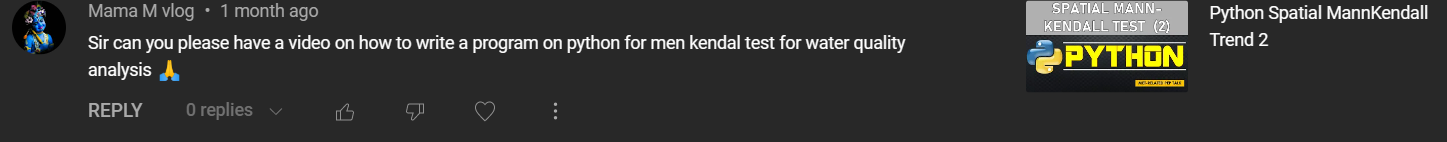

# Applying Mann-Kendall Test on Any Point or Spatial Timeseries

In [ ]:
import pymannkendall as mk
import pandas as pd

In [ ]:
df_Tabular_Data = pd.read_csv("C:/Users/UncleJay/Desktop/Projects/WASCAL_TimeSeries_Training/data/Tamale_CRU_rainfall.csv")

df_Tabular_Data

In [ ]:
# Point Data
df_Tabular_Data = pd.read_csv("C:/Users/UncleJay/Desktop/Projects/WASCAL_TimeSeries_Training/data/Tamale_CRU_rainfall.csv")
df_Tabular_Data['Year'] = df_Tabular_Data.PRE.dropna().astype('int').astype('str')
df_Tabular_Data = df_Tabular_Data.drop(['PRE','Unnamed: 13'], axis=1).dropna()
df_Tabular_Data = df_Tabular_Data.set_index('Year')
df_Tabular_Data

# Apply MK test on single column data

In [ ]:
mk.original_test(df_Tabular_Data.Jan)

# Multi-Column Data

In [ ]:
df_Tabular_Data.apply(mk.original_test)

# Spatial Application

In [ ]:
import xarray as xr
df_spatial_data = xr.open_dataset("C:/Users/UncleJay/Desktop/Projects/WASCAL_TimeSeries_Training/data/rainfall.nc")
da_RR = df_spatial_data['pr'] * 86400

In [ ]:
da_RR

In [ ]:
xr.apply_ufunc(lambda x: mk.original_test(x).slope,
              da_RR.sel(time=slice('2001','2002')),
              input_core_dims=[['time']],
              vectorize=True).plot()

# Thank You